<a href="https://colab.research.google.com/github/Prima-Rizky/Data-Driven-Retail-Optimasi-Profit-Prediksi-Penjualan/blob/main/Data_Driven_Retail_Optimasi_Profit_%26_Prediksi_Penjualan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tahap 1: Pengolahan Data dan Rekayasa Fitur

> memastikan data bersih, dalam format yang benar, dan memiliki semua variabel yang kita butuhkan untuk analisis selanjutnya.

In [513]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import skew
from prophet import Prophet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D


df = pd.read_csv('Superstore.csv', encoding='latin1')

pd.set_option('display.max_columns', None)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [514]:
# Informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [515]:
print("==== mengecek apakah ada data duplikat ====")
df.duplicated().sum()
print("\n")
print("==== mengecek apakah ada data yang hilang ====")
df.isnull().sum()

==== mengecek apakah ada data duplikat ====


==== mengecek apakah ada data yang hilang ====


,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [516]:
print("==== statistika deskriptif ====")
df.describe()

==== statistika deskriptif ====


,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [517]:
# Konversi kolom 'Order Date' dan 'Ship Date' ke tipe datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format= '%m/%d/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format= '%m/%d/%Y', errors='coerce')

# Ekstrak fitur waktu baru dari 'Order Date'
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Quarter'] = df['Order Date'].dt.quarter

# Hitung durasi pengiriman dalam hari
df['Shipping Duration'] = (df['Ship Date'] - df['Order Date']).dt.days

In [518]:
# Memeriksa anomali pada kolom numerik
print(df[['Sales', 'Quantity', 'Discount', 'Profit']].describe())

print('\n')

# Cek nilai negatif
print("kolom Quantity")
print(df[df['Quantity'] < 0].shape[0])
print("\nkolom Sales")
print(df[df['Sales'] < 0].shape[0])

              Sales     Quantity     Discount       Profit
count   9994.000000  9994.000000  9994.000000  9994.000000
mean     229.858001     3.789574     0.156203    28.656896
std      623.245101     2.225110     0.206452   234.260108
min        0.444000     1.000000     0.000000 -6599.978000
25%       17.280000     2.000000     0.000000     1.728750
50%       54.490000     3.000000     0.200000     8.666500
75%      209.940000     5.000000     0.200000    29.364000
max    22638.480000    14.000000     0.800000  8399.976000


kolom Quantity
0

kolom Sales
0


In [519]:
# Profit Margin
df['Profit Margin (%)'] = np.where(df['Sales'] > 0, (df['Profit'] / df['Sales']) * 100, 0)

In [520]:
# Menghitung RFM (Recency, Frequency, Monetary)
latest_date = df['Order Date'].max() + dt.timedelta(days=1)

rfm_df = df.groupby('Customer ID').agg(
    Recency=('Order Date', lambda date: (latest_date - date.max()).days),
    Frequency=('Order ID', 'nunique'),
    Monetary=('Sales', 'sum')
).reset_index()

In [521]:
# Mengecek data setelah penambahan fitur
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Row ID             9994 non-null   int64         
 1   Order ID           9994 non-null   object        
 2   Order Date         9994 non-null   datetime64[ns]
 3   Ship Date          9994 non-null   datetime64[ns]
 4   Ship Mode          9994 non-null   object        
 5   Customer ID        9994 non-null   object        
 6   Customer Name      9994 non-null   object        
 7   Segment            9994 non-null   object        
 8   Country            9994 non-null   object        
 9   City               9994 non-null   object        
 10  State              9994 non-null   object        
 11  Postal Code        9994 non-null   int64         
 12  Region             9994 non-null   object        
 13  Product ID         9994 non-null   object        
 14  Category

# Tahap 2: Analisis Data Eksplorasi (EDA) dan Wawasan Bisnis

> mencari pola dan wawasan tersembunyi yang langsung bisa diterjemahkan ke dalam strategi bisnis

Bagian 1: Analisis Profitabilitas Produk

In [522]:
profit_by_category = df.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit', 'Quantity']].sum().sort_values(by='Profit', ascending=False)
print(profit_by_category)

                                    Sales      Profit  Quantity
Category        Sub-Category                                   
Technology      Copiers       149528.0300  55617.8249       234
                Phones        330007.0540  44515.7306      3289
                Accessories   167380.3180  41936.6357      2976
Office Supplies Paper          78479.2060  34053.5693      5178
                Binders       203412.7330  30221.7633      5974
Furniture       Chairs        328449.1030  26590.1663      2356
Office Supplies Storage       223843.6080  21278.8264      3158
                Appliances    107532.1610  18138.0054      1729
Furniture       Furnishings    91705.1640  13059.1436      3563
Office Supplies Envelopes      16476.4020   6964.1767       906
                Art            27118.7920   6527.7870      3000
                Labels         12486.3120   5546.2540      1400
Technology      Machines      189238.6310   3384.7569       440
Office Supplies Fasteners       3024.280

Bagian 2: Visualisasi Analisis Profitabilitas Produk


> Tujuan: Membuat grafik yang menunjukkan profit setiap sub-kategori secara visual, sehingga kita bisa dengan cepat mengidentifikasi mana yang untung dan mana yang rugi



In [523]:
profit_by_category = df.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(by='Profit', ascending=False)
profit_by_category = profit_by_category.reset_index()

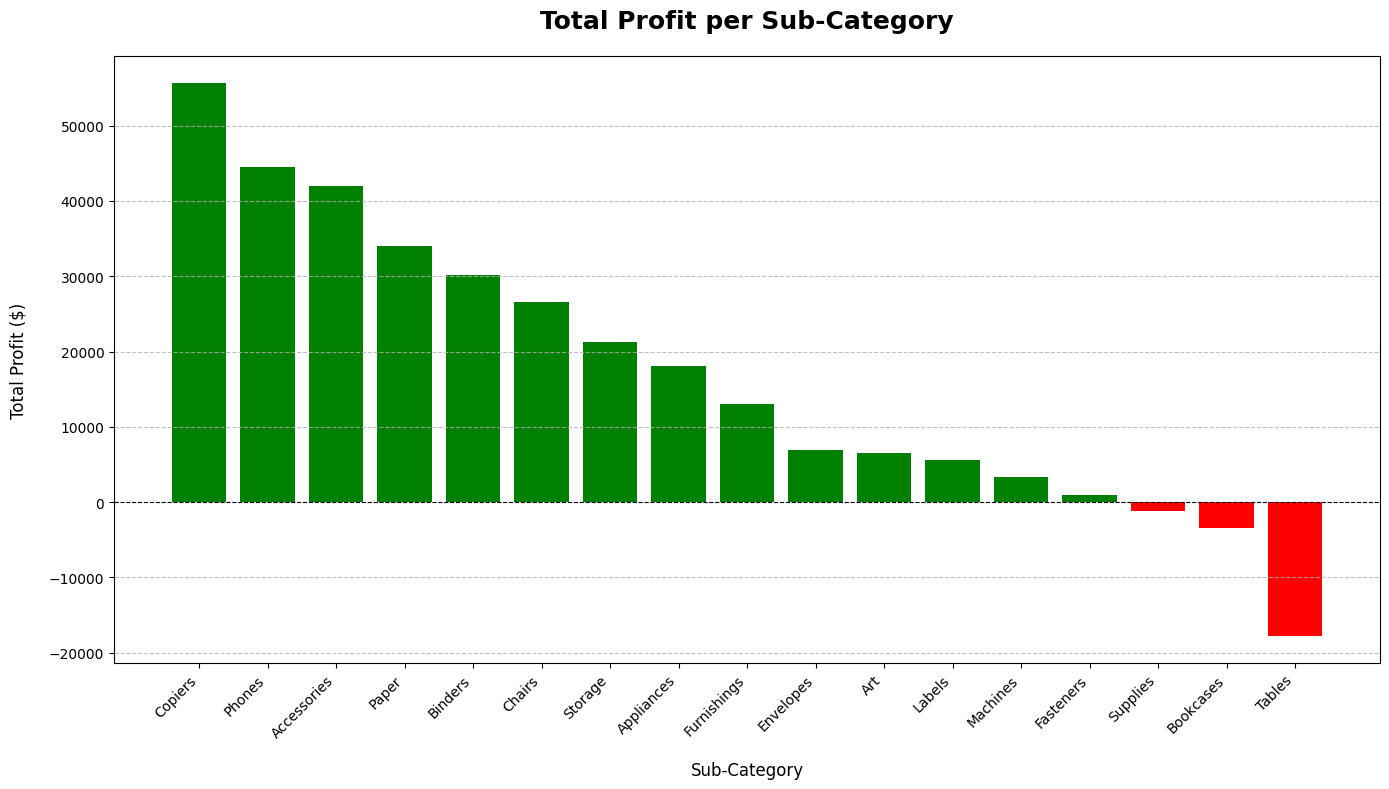

In [524]:
plt.figure(figsize=(14, 8))
# hijau untuk profit, merah untuk rugi
colors = ['green' if x > 0 else 'red' for x in profit_by_category['Profit']]
plt.bar(profit_by_category['Sub-Category'], profit_by_category['Profit'], color=colors)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.title('Total Profit per Sub-Category', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sub-Category', fontsize=12, labelpad=15)
plt.ylabel('Total Profit ($)', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()

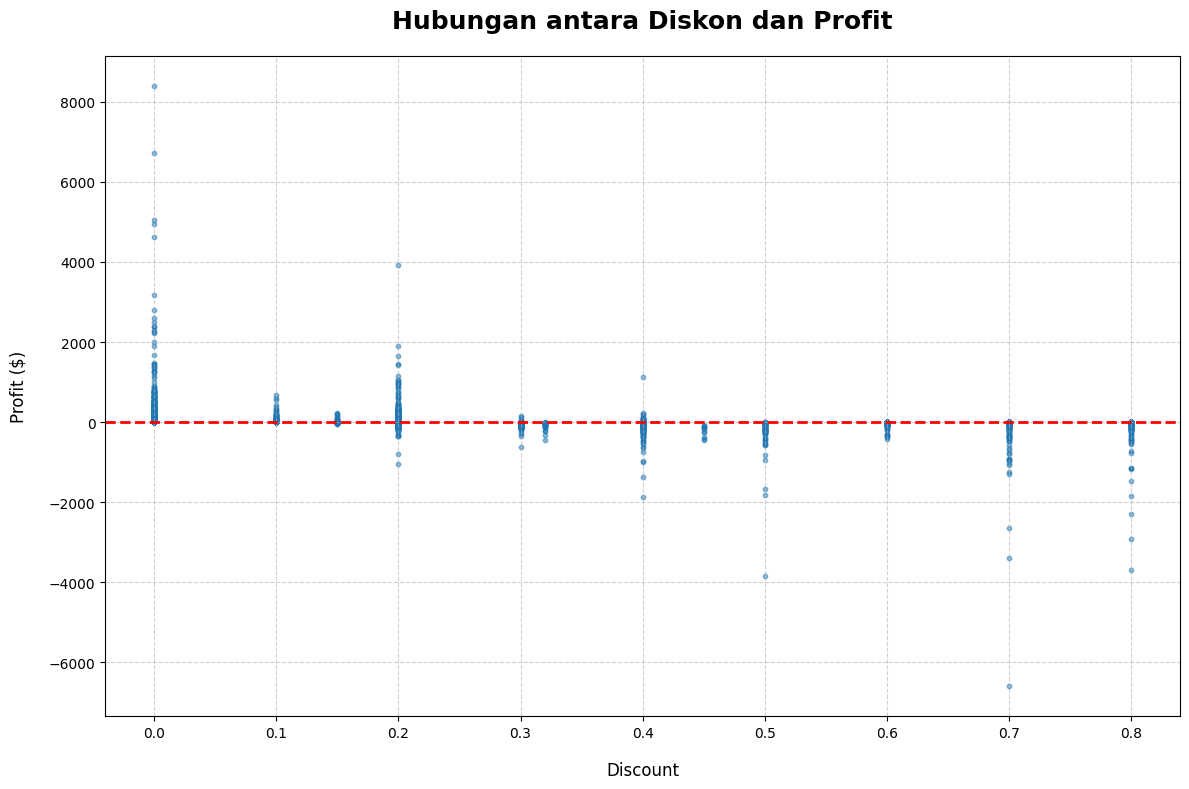

In [525]:
# Buat scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(df['Discount'], df['Profit'], alpha=0.5, s=10)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Hubungan antara Diskon dan Profit', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Discount', fontsize=12, labelpad=15)
plt.ylabel('Profit ($)', fontsize=12, labelpad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

Berdasarkan visualisasi scatter plot yang menganalisis hubungan antara diskon yang diberikan dan keuntungan yang didapat, saya menemukan wawasan kritis terkait profitabilitas:


> **Mayoritas Transaksi Menguntungkan:** Sebagian besar penjualan berada di zona profit positif, menandakan bahwa operasional bisnis secara umum berjalan dengan baik dan menghasilkan keuntungan


> **Korelasi Negatif yang Signifikan:** Terdapat hubungan negatif yang jelas antara Diskon dan Profit. Semakin besar diskon yang diberikan, semakin tinggi risikonya untuk mengalami kerugian


> **Diskon Tinggi, Risiko Kerugian Tinggi:** Analisis visual menunjukkan bahwa hampir semua transaksi dengan diskon di atas 30% (0.3) berpotensi besar menyebabkan kerugian. Hal ini membuktikan bahwa kebijakan diskon yang agresif menjadi faktor utama yang mengikis profitabilitas


> **Kerugian Tak Terduga di Diskon Rendah:** Menariknya, ditemukan juga beberapa transaksi yang menghasilkan kerugian meskipun diskon yang diberikan relatif kecil (<= 20%). Hal ini mengindikasikan adanya faktor-faktor lain di luar diskon yang turut memengaruhi profitabilitas, seperti biaya operasional, harga pokok barang, atau biaya pengiriman



In [526]:
# Hitung koefisien korelasi
# Koefisien korelasi mengukur kekuatan dan arah hubungan linier antara dua variabel. Nilainya berkisar dari -1 hingga +1
# +1: Korelasi positif sempurna (jika Diskon naik, Profit juga cenderung naik)
# 0: Tidak ada korelasi linier (tidak ada hubungan yang jelas antara Diskon dan Profit)
# -1: Korelasi negatif sempurna (jika Diskon naik, Profit cenderung turun)

correlation = df['Discount'].corr(df['Profit'])
print(f'Koefisien Korelasi antara Diskon dan Profit: {correlation:.4f}')

Koefisien Korelasi antara Diskon dan Profit: -0.2195


Nilai **-0.2195** menunjukkan adanya **korelasi negatif yang lemah hingga sedang** antara Diskon dan Profit. Ini berarti bahwa:



> **Arah Hubungan:** Hubungannya bersifat negatif. Artinya, ketika nilai diskon meningkat, profit cenderung menurun.


> **Kekuatan Hubungan:** Korelasi ini tidak sempurna, yang ditunjukkan oleh nilai yang tidak mendekati -1. Ini mengindikasikan bahwa diskon bukanlah satu-satunya faktor yang memengaruhi profit. Ada variabel lain yang juga berperan, seperti harga jual produk, biaya produksi, atau biaya pengiriman.



Dari hasil analisis, saya mendapatkan beberapa wawasan penting yang dapat menjadi dasar pengambilan keputusan strategis:


> **Validasi Hubungan Negatif Diskon & Profit:** Analisis kuantitatif menguatkan temuan visual: terdapat korelasi negatif yang kuat antara tingkat diskon dan profitabilitas. Ini membuktikan bahwa diskon yang agresif secara langsung mengikis margin keuntungan


> **Strategi Diskon yang Lebih Cerdas Diperlukan:** Berdasarkan temuan ini, tim sales dan marketing perlu mengadopsi kebijakan diskon yang lebih strategis dan selektif. Diskon besar sebaiknya dipertimbangkan dengan cermat, terutama untuk produk dengan margin keuntungan yang tipis


> **Pentingnya Investigasi Lanjutan:** Analisis ini mengungkap adanya transaksi yang merugi meskipun diskonnya kecil. Hal ini menyoroti perlunya investigasi mendalam terhadap faktor-faktor lain yang memengaruhi profit, seperti biaya operasional, logistik, atau harga pokok produk

Bagian 3: Analisis Tren Waktu


> **Tujuan Bisnis:** Mengidentifikasi pola musiman penjualan dan profit untuk perencanaan inventaris dan kampanye marketing di masa depan.






In [527]:
# Agregasi data penjualan dan profit bulanan
monthly_trends = df.set_index('Order Date').resample('MS').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()
print(monthly_trends.head())

  Order Date      Sales     Profit
0 2014-01-01  14236.895  2450.1907
1 2014-02-01   4519.892   862.3084
2 2014-03-01  55691.009   498.7299
3 2014-04-01  28295.345  3488.8352
4 2014-05-01  23648.287  2738.7096


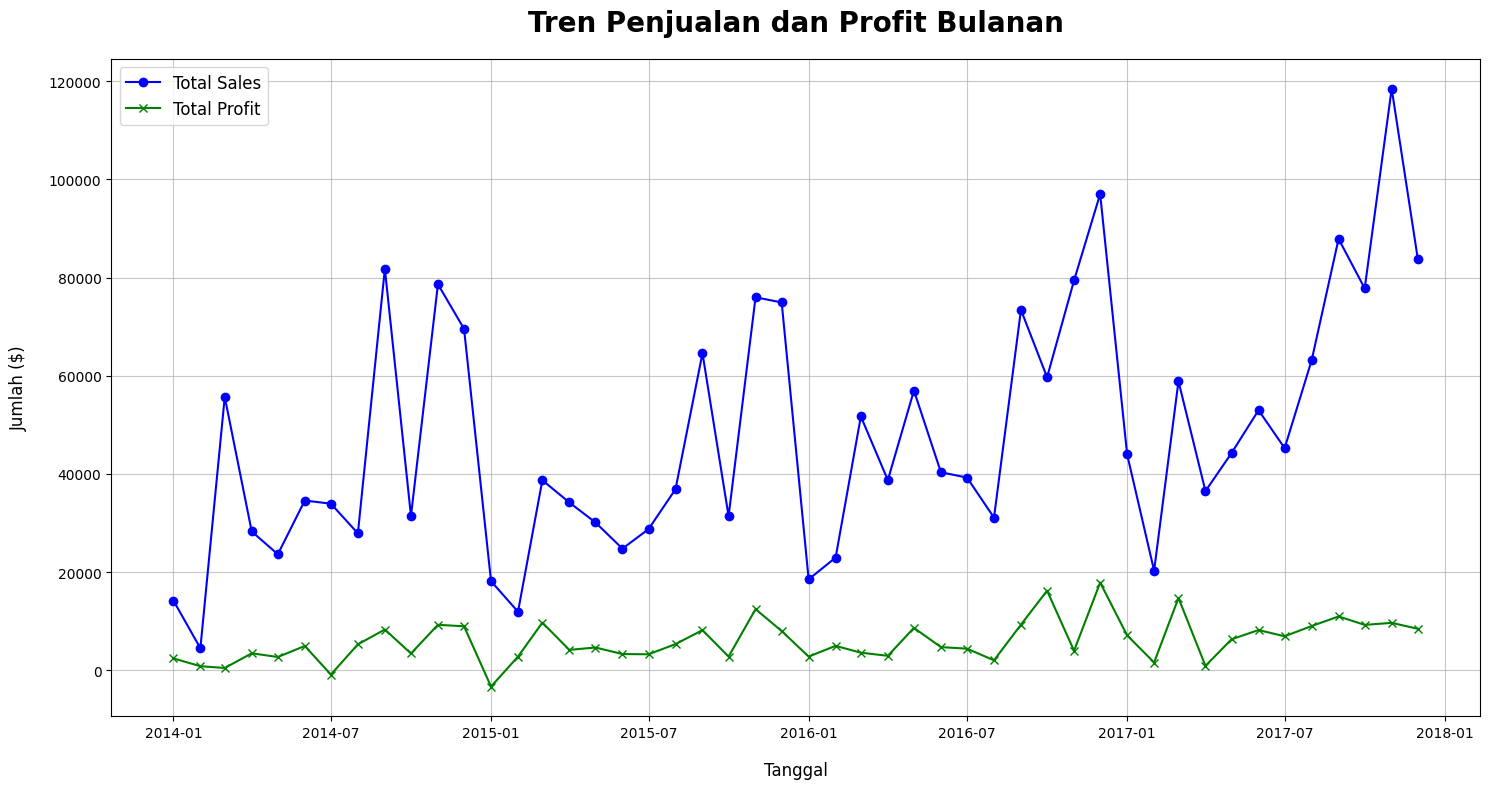

In [528]:
# Plot tren penjualan dan profit bulanan
plt.figure(figsize=(15,8))
plt.plot(monthly_trends['Order Date'], monthly_trends['Sales'], label='Total Sales', color='blue', marker='o', linestyle='-')
plt.plot(monthly_trends['Order Date'], monthly_trends['Profit'], label='Total Profit', color='green', marker='x', linestyle='-')

plt.title('Tren Penjualan dan Profit Bulanan', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Tanggal', fontsize=12, labelpad=15)
plt.ylabel('Jumlah ($)', fontsize=12, labelpad=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

Berdasarkan analisis data penjualan dari tahun 2014 hingga 2017, saya menemukan beberapa tren bisnis yang signifikan:


> **Pola Musiman yang Kuat:** Penjualan dan keuntungan menunjukkan lonjakan yang konsisten di setiap **Kuartal ke-4.** Hal ini mengindikasikan adanya peningkatan permintaan yang tajam selama periode akhir tahun, terutama musim liburan.


> **Pertumbuhan Penjualan yang Positif:** Terlihat adanya tren peningkatan Total Sales dari tahun ke tahun, puncaknya mencapai lebih dari $100.000 di akhir 2017. Ini menandakan ekspansi pasar yang sukses.


> **Volatilitas Keuntungan yang Krusial:** Meskipun penjualan terus bertumbuh, Total Profit menunjukkan fluktuasi yang ekstrem dan cenderung stagnan. Ada beberapa periode di mana perusahaan mengalami kerugian, bahkan saat penjualan sedang tinggi. Hal ini menjadi area fokus utama untuk investigasi lebih lanjut guna mengidentifikasi faktor-faktor yang mempengaruhi profitabilitas.








Bagian: 4 Analisis Geografis


> **Tujuan Bisnis:** Memahami kinerja penjualan dan profit di berbagai wilayah untuk alokasi sumber daya, strategi pemasaran, dan perencanaan logistik yang lebih baik



In [529]:
# Agregasi total Sales dan Profit berdasarkan Region
regional_performance = df.groupby('Region').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).sort_values(by='Sales', ascending=False)

# Hitung Profit Margin (%) untuk setiap wilayah
regional_performance['Profit Margin ($)'] = (regional_performance['Profit'] / regional_performance['Sales']) * 100

print("Kinerja Penjualan dan Profit Berdasarkan Wilayah:")
print(regional_performance)

Kinerja Penjualan dan Profit Berdasarkan Wilayah:
               Sales       Profit  Profit Margin ($)
Region                                              
West     725457.8245  108418.4489          14.944831
East     678781.2400   91522.7800          13.483399
Central  501239.8908   39706.3625           7.921629
South    391721.9050   46749.4303          11.934342


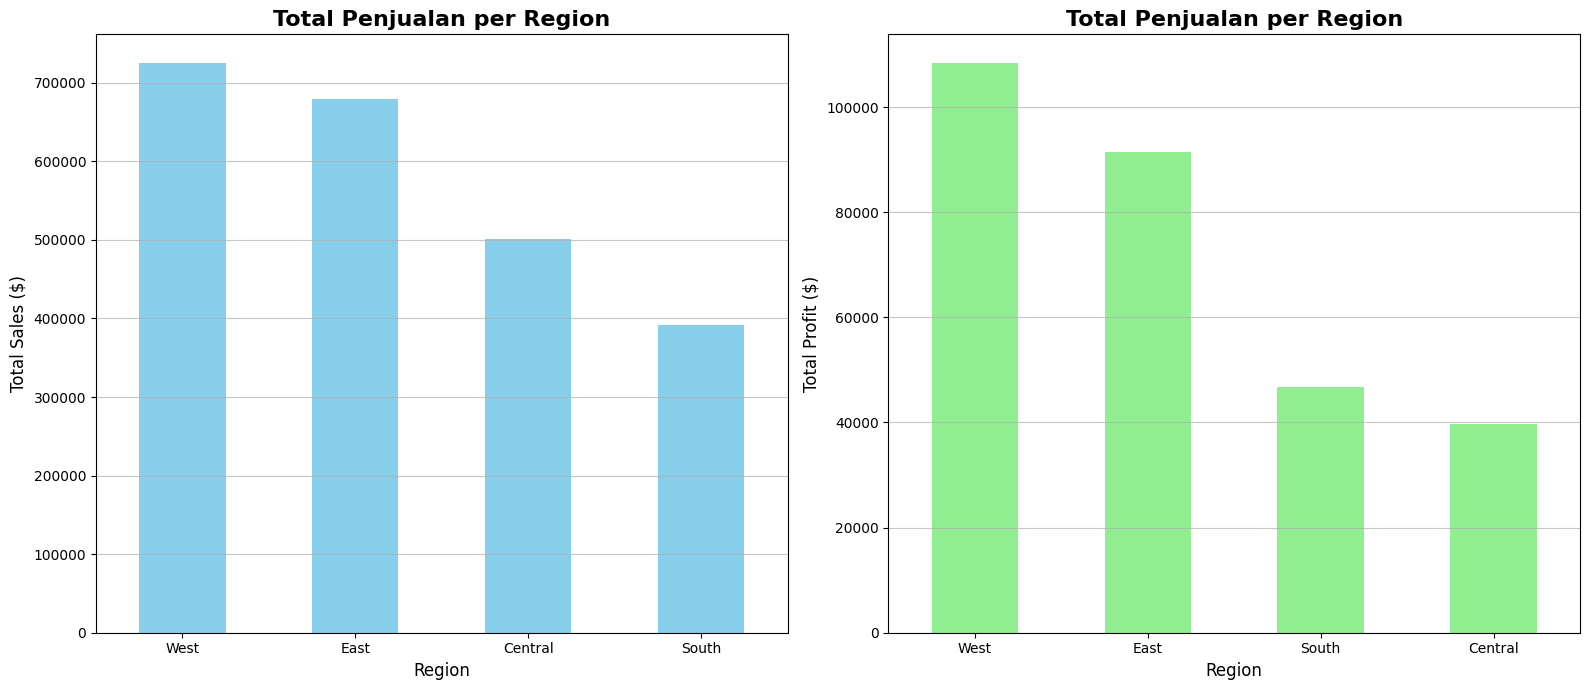

In [530]:
# Buat bar chart untuk Sales dan Profit per Region
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Bar chart untuk Sales
regional_performance['Sales'].sort_values(ascending=False).plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Total Penjualan per Region', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Region', fontsize=12)
ax[0].set_ylabel('Total Sales ($)', fontsize=12)
ax[0].tick_params(axis='x', rotation=0)
ax[0].grid(axis='y', linestyle='-', alpha=0.7)

# Bar chart untuk Profit
regional_performance['Profit'].sort_values(ascending=False).plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Total Penjualan per Region', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Region', fontsize=12)
ax[1].set_ylabel('Total Profit ($)', fontsize=12)
ax[1].tick_params(axis='x', rotation=0)
ax[1].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout()
plt.show()

Dari grafik dan data yang telah dianalisis, kita mendapatkan wawasan bisnis yang sangat berharga mengenai kinerja di setiap wilayah:

Wilayah Barat (West): Juara Penjualan dan Profit

Wilayah West tidak hanya menjadi pasar dengan Total Sales tertinggi, tetapi juga paling menguntungkan dengan Total Profit tertinggi. Ini mengindikasikan bahwa strategi yang diterapkan di wilayah ini sangat efektif


> Wawasan: Wilayah West harus menjadi prioritas utama untuk investasi dan ekspansi lebih lanjut. Strategi pemasaran, penjualan, dan operasional yang berhasil di sini bisa menjadi model bisnis untuk wilayah lain

Wilayah Timur (East): Pesaing Kuat

Wilayah East menunjukkan kinerja yang solid, menempati posisi kedua dalam hal penjualan dan profit. Ini membuktikan bahwa East adalah pasar yang matang dengan potensi pertumbuhan yang besar


> Wawasan: Wilayah ini memiliki potensi untuk menjadi pasar dominan kedua. Mengalokasikan sumber daya yang memadai, mirip dengan yang diberikan kepada West, dapat membantu memaksimalkan potensi keuntungannya

Wilayah Selatan (South) vs. Tengah (Central): Perbedaan Profit Margin

Ini adalah temuan paling krusial. Meskipun Total Sales di wilayah Central lebih tinggi daripada di South, Total Profit di South justru lebih besar. Perbedaan ini tercermin jelas pada Profit Margin:



> Central: Profit Margin hanya 7.92%


> South: Profit Margin mencapai 11.93%


> Wawasan: Wilayah Central adalah kasus yang menarik. Wilayah ini sibuk dengan penjualan, tetapi tidak efisien dalam menghasilkan keuntungan. Perlu dilakukan investigasi mendalam untuk mengidentifikasi penyebab margin yang rendah ini. Apakah karena kebijakan diskon yang terlalu agresif, biaya pengiriman yang tinggi, atau penjualan produk dengan margin rendah? Ini adalah masalah bisnis kritis yang memerlukan perhatian segera untuk mengubah aktivitas penjualan menjadi profit yang nyata


> Solusi Awal: Fokuskan investasi dan sumber daya ke wilayah West dan East untuk memaksimalkan keuntungan. Untuk wilayah Central, kita perlu melakukan audit biaya atau strategi harga untuk memahami mengapa profitnya sangat rendah.












# Tahap 3: Implementasi Model Machine Learning (Prediktif)

> membangun alat cerdas yang secara otomatis mengelompokkan pelanggan dan membuat prediksi, sehingga tim marketing bisa membuat keputusan yang lebih cerdas dan personal

Bagian 1: Segmentasi Pelanggan (Clustering)

In [531]:
# cek skewness pada RFM
print("Skewness pada data RFM")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].skew())

Skewness pada data RFM
Recency      2.276395
Frequency    0.362409
Monetary     2.476555
dtype: float64


In [532]:
# transformasi logaritma untuk "meratakan" distribusi data (saya menggunakan fungsi copy agar tidak mengubah data aslinya)
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
rfm_log['Recency'] = rfm_log['Recency'].apply(lambda x: np.log(x + 1))
rfm_log['Frequency'] = rfm_log['Frequency'].apply(lambda x: np.log(x + 1))
rfm_log['Monetary'] = rfm_log['Monetary'].apply(lambda x: np.log(x + 1))

In [533]:
# penskalaan data menggunakan StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'])

print("Data RFM setelah penskalaan")
print(rfm_scaled.head())

Data RFM setelah penskalaan
   Recency_Scaled  Frequency_Scaled  Monetary_Scaled
0        0.728424         -0.344103         1.013567
1       -1.003118          0.994033        -0.568377
2        0.997357         -0.821704        -0.066099
3       -0.210446          0.059703         0.928264
4        1.369323         -1.406241        -0.735599


In [534]:
# menemukan jumlah Klaster Optimal (Elbow Method)
# inisialisasi list untuk Inertia (Sum of Squared Distances)
sse = []
k_range = range(1,11)

# jalankan K-Means untuk setiap nilai k
for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(rfm_scaled)
  sse.append(kmeans.inertia_)

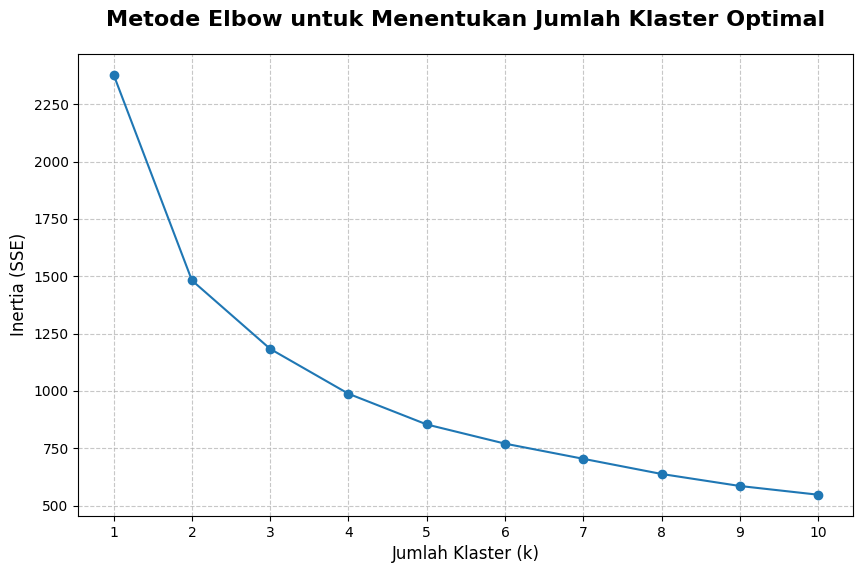

In [535]:
# plot ELbow Method
plt.figure(figsize=(10,6))
plt.plot(k_range, sse, marker='o')
plt.title('Metode Elbow untuk Menentukan Jumlah Klaster Optimal', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Jumlah Klaster (k)', fontsize=12)
plt.ylabel('Inertia (SSE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.show()

Berdasarkan visualisasi Metode Elbow, kami mengidentifikasi titik 'siku' (elbow point) yang optimal pada k = 4. Pada titik ini, penurunan nilai Inertia (Sum of Squared Errors) mulai melandai secara substansial, menandakan bahwa penambahan klaster di atas 4 akan memberikan manfaat yang minimal. Pemilihan ini merepresentasikan keseimbangan terbaik untuk mendapatkan segmen yang bermakna dan kompak

In [536]:
# menerapkan K-Means dengan Elbow Point
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(rfm_scaled)

# nenambahkan label klaster ke dataframe RFM asli
rfm_df['Cluster'] = kmeans_model.labels_

# analisis karakteristik setiap klaster
# hitung rata - rata RFM untuk setiap klaster
cluster_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).sort_values(by='Monetary', ascending=False)

print("Profil rata-rata setiap klaster")
print(cluster_profiles)

Profil rata-rata setiap klaster
            Recency  Frequency     Monetary
Cluster                                    
2        103.333333   8.589147  4773.039956
0         19.723618   6.783920  2712.878566
1        235.221344   4.857708  1936.831874
3        326.638554   2.578313   432.231961


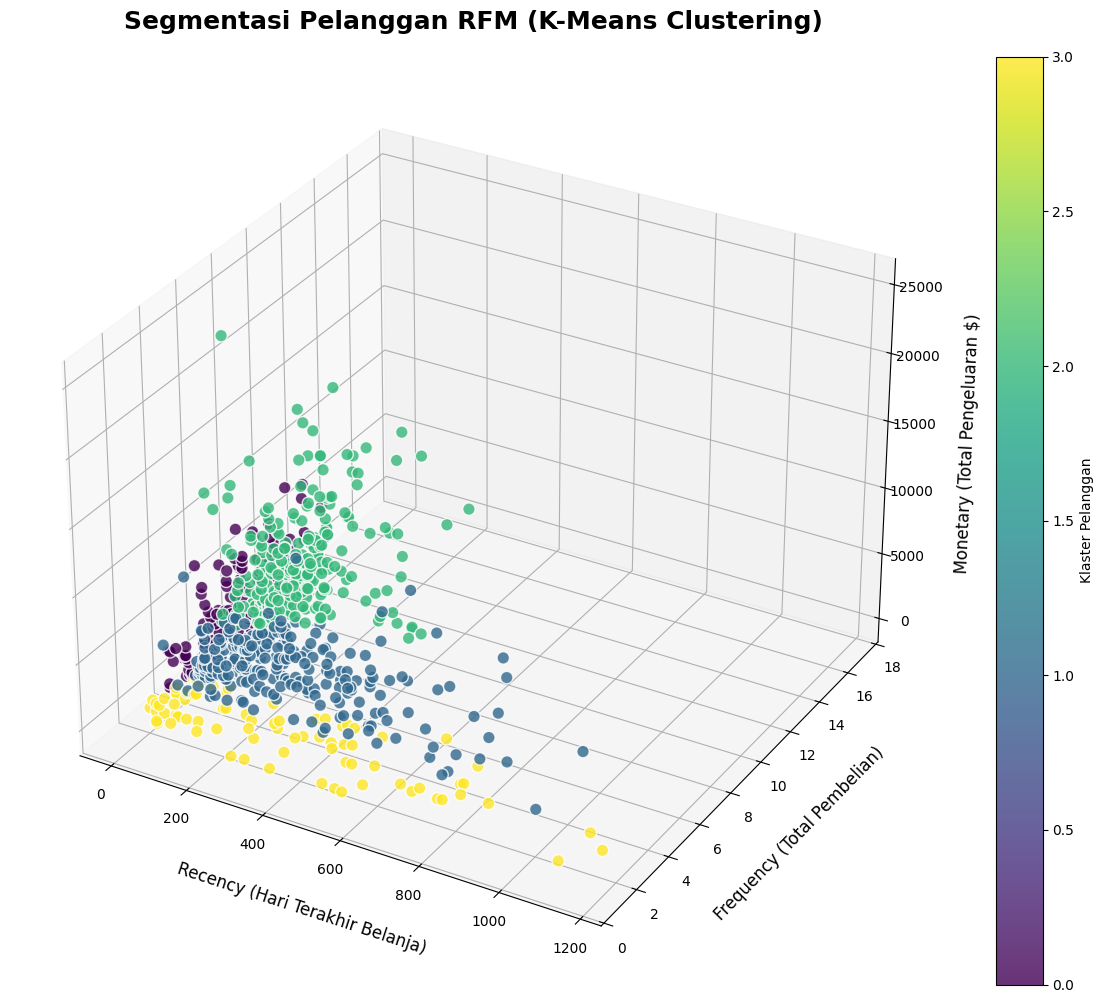

In [537]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D menggunakan rfm_df yang sudah ada kolom 'Cluster'
scatter = ax.scatter(rfm_df['Recency'], rfm_df['Frequency'], rfm_df['Monetary'],
                     c=rfm_df['Cluster'], cmap='viridis', s=80, alpha=0.8, edgecolor='w')

ax.set_title('Segmentasi Pelanggan RFM (K-Means Clustering)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Recency (Hari Terakhir Belanja)', fontsize=12, labelpad=15)
ax.set_ylabel('Frequency (Total Pembelian)', fontsize=12, labelpad=15)
ax.set_zlabel('Monetary (Total Pengeluaran $)', fontsize=12, labelpad=15)

plt.colorbar(scatter, label='Klaster Pelanggan')
plt.tight_layout()

Analisis & Interpretasi Klaster Pelanggan
Kita telah berhasil mengelompokkan pelanggan ke dalam 4 segmen strategis. Berikut adalah deskripsi dan rekomendasi untuk setiap segmen:

**Klaster 0: "Champions" (Pelanggan Juara)**

**Profil:**



*   Recency sangat rendah (19.7 hari)
*   Frequency tinggi (6.7 kali)
*   Monetary tinggi ($2,712)


> **Deskripsi:** Ini adalah pelanggan terbaik kita. Mereka baru saja berbelanja, sering berbelanja, dan menghabiskan banyak uang. Mereka adalah tulang punggung bisnis dan merupakan pendukung setia merek kita.


> **Rekomendasi Bisnis:**
Berikan Perlakuan VIP: Kirimkan penawaran eksklusif, akses awal ke produk baru, atau undangan ke acara khusus.
Program Referensi: Dorong mereka untuk mengajak teman-teman mereka dengan insentif yang menarik.
**Ide Tambahan:** Gunakan klaster ini sebagai "look-alike audience" di kampanye iklan digital untuk menemukan pelanggan baru yang memiliki profil serupa.


**Klaster 2: "High-Value" (Pelanggan Nilai Tinggi)**

**Profil:**


*   Recency sedang (103.3 hari)
*   Frequency sangat tinggi (8.5 kali)
*   Item daftarMonetary tertinggi ($4,773)



> **Deskripsi:** Pelanggan ini menghabiskan uang paling banyak dan paling sering berbelanja di masa lalu, meskipun sudah agak lama tidak berbelanja. Mereka adalah aset berharga yang harus dipertahankan.



> **Rekomendasi Bisnis:**
Kampanye Retensi & Reaktivasi: Kirimkan email atau notifikasi personal yang mengingatkan mereka tentang produk favorit atau menawarkan diskon untuk mendorong pembelian berikutnya.
Survei Feedback: Tanyakan alasan mengapa mereka belum berbelanja lagi untuk memahami kebutuhan mereka.
**Ide Tambahan:** Identifikasi produk yang paling sering mereka beli dan tawarkan rekomendasi produk yang melengkapi pembelian tersebut.






**Klaster 1: "At-Risk" (Pelanggan Berisiko)**

**Profil:**


*   Recency tinggi (235.2 hari)
*   Frequency sedang (4.8 kali)
*   Monetary sedang ($1,936)


> **Deskripsi:** Pelanggan ini dulunya aktif, tetapi sudah lama tidak berbelanja. Mereka berada di ambang churn (tidak kembali lagi). Jika kita tidak bertindak, kita akan kehilangan mereka.

> **Rekomendasi Bisnis:**
Kampanye Penyelamatan: Berikan insentif yang kuat seperti diskon besar atau penawaran "beli 1 gratis 1" yang waktunya terbatas untuk mendorong mereka kembali.
Coba Jangkau di Berbagai Saluran: Jika email tidak berhasil, coba jangkau mereka melalui SMS atau media sosial.




**Klaster 3: "Hibernating" (Pelanggan Tidur)**

**Profil:**


*   Recency sangat tinggi (326.6 hari)
*   Frequency rendah (2.5 kali)
*   Monetary rendah ($432)

> **Deskripsi:** Pelanggan ini sudah lama tidak aktif dan tidak pernah menjadi pembelanja yang sering atau besar. Mereka sudah hampir "hilang".

> **Rekomendasi Bisnis:**
Hemat Sumber Daya: Hindari menghabiskan banyak anggaran marketing untuk klaster ini.
Kampanye Khusus: Coba satu kali kampanye massal dengan penawaran yang sangat menarik. Jika tidak ada respons, lebih baik alihkan fokus ke klaster yang lebih berpotensi.










Bagian 2: Peramalan Penjualan (Forecasting)

In [538]:
# dataframe untuk Prophet
# Prophet memerlukan dua kolom: 'ds' (datestamp) dan 'y' (value to predict)
forecast_df = monthly_trends[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

print("Dataframe untuk Forecasting")
print(forecast_df.head())

Dataframe untuk Forecasting
          ds          y
0 2014-01-01  14236.895
1 2014-02-01   4519.892
2 2014-03-01  55691.009
3 2014-04-01  28295.345
4 2014-05-01  23648.287


In [539]:
# inisialisasi model Prophet
m = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# melatih model dengan data histori
m.fit(forecast_df)

# membuat dataframe untuk prediksi di masa depan(24 bulan ke depan)
future = m.make_future_dataframe(periods=24, freq='MS')

# melakukan prediksi
forecast = m.predict(future)

print("Hasil Prediksi:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

DEBUG:cmdstanpy:input tempfile: /tmp/tmplq_tp3yd/9tqvtow3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplq_tp3yd/n3oy31oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26613', 'data', 'file=/tmp/tmplq_tp3yd/9tqvtow3.json', 'init=/tmp/tmplq_tp3yd/n3oy31oe.json', 'output', 'file=/tmp/tmplq_tp3yd/prophet_modele1ur1du9/prophet_model-20250630144745.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:47:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Hasil Prediksi:
           ds           yhat     yhat_lower     yhat_upper
67 2019-08-01   68302.641088   58552.655261   78085.225963
68 2019-09-01  123145.707770  113773.687257  132871.628551
69 2019-10-01   57864.149364   47602.504116   67655.793768
70 2019-11-01  138717.874896  128978.253264  148479.965461
71 2019-12-01  117347.872481  107375.257622  126579.659707


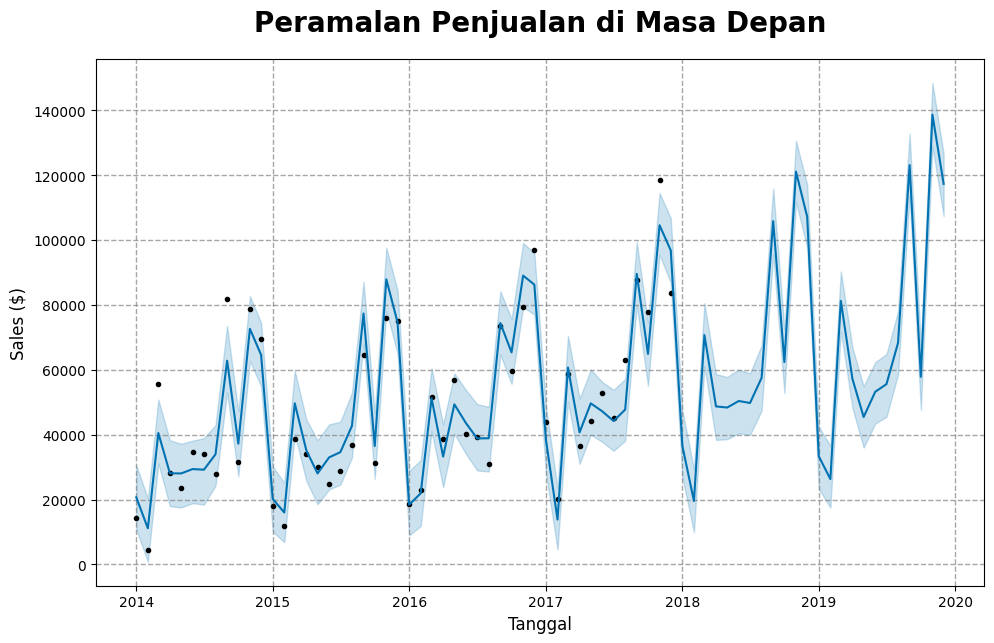

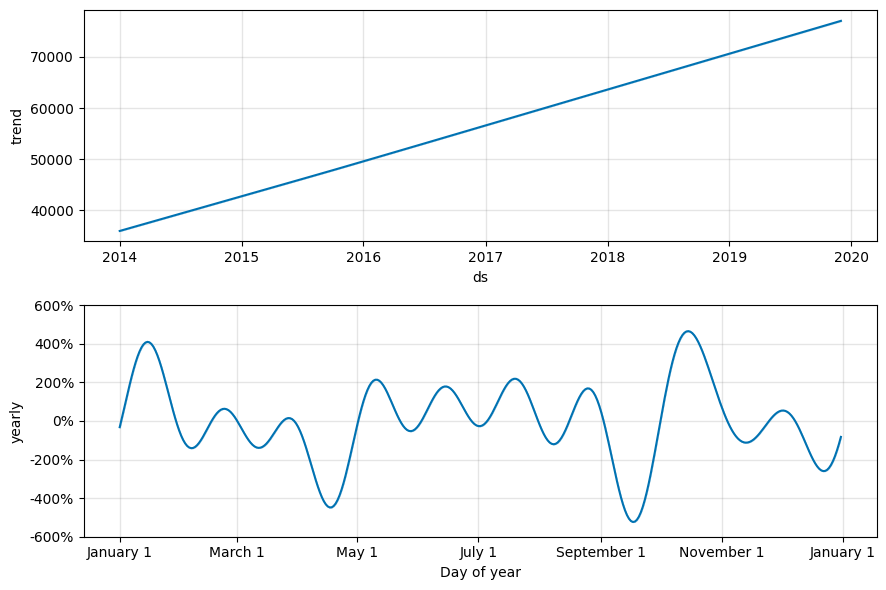

In [540]:
# visualisasi hasil prediksi
fig1 = m.plot(forecast)

ax = fig1.gca()
ax.set_title('Peramalan Penjualan di Masa Depan', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Tanggal', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# visualisasi komponen trem, musiman, dan dll
fig2 = m.plot_components(forecast)

Visualisasi di atas memberikan panduan strategis yang jelas untuk masa depan bisnis kita. Berdasarkan data historis dan prediksi model, kita dapat menarik wawasan kunci berikut:

1. Tren Pertumbuhan Jangka Panjang yang Kuat
Model memprediksi bahwa total penjualan akan terus menunjukkan tren pertumbuhan yang stabil dan meningkat dari tahun ke tahun. Ini adalah indikasi kesehatan bisnis yang sangat positif dan memberikan keyakinan untuk melakukan investasi lebih lanjut, seperti ekspansi pasar atau peningkatan kapasitas operasional.

2. Pola Musiman yang Terprediksi
Analisis menunjukkan bahwa bisnis kita memiliki pola musiman yang konsisten setiap tahun. Terdapat dua puncak penjualan yang signifikan:

 *   Puncak Utama (Q4): Lonjakan penjualan terbesar terjadi di bulan Oktober hingga November setiap tahun. Ini adalah periode emas bagi bisnis kita, kemungkinan besar dipicu oleh musim liburan dan kampanye akhir tahun.
 *   Puncak Sekunder (Q2): Ada juga lonjakan penjualan yang lebih kecil di sekitar bulan Juni hingga Juli.


3. Periode Penurunan yang Dapat Diantisipasi
Sebaliknya, model juga mengidentifikasi periode dengan penjualan yang lebih rendah, terutama di awal tahun (Februari - Maret). Ini bukan pertanda buruk, melainkan pola yang bisa kita manfaatkan.


**Rekomendasi Bisnis yang Dapat Ditindaklanjuti:**

**Dengan wawasan ini, tim bisnis dapat beralih dari reaktif menjadi proaktif:**
*   **Untuk Tim Marketing:** Alokasikan anggaran terbesar untuk kampanye promosi dan iklan pada bulan Oktober-November dan Juni-Juli untuk memaksimalkan dua puncak penjualan yang diprediksi.
*   **Untuk Tim Operasional & Logistik:** Lakukan perencanaan inventaris jauh-jauh hari sebelum bulan-bulan puncak. Mulai tingkatkan stok produk pada bulan September untuk mengantisipasi lonjakan permintaan di akhir tahun.
*   **Untuk Tim Keuangan:** Gunakan angka prediksi (yhat) dan rentang kepercayaannya (yhat_lower, yhat_upper) untuk menyusun anggaran pendapatan dan kas yang lebih akurat untuk tahun-tahun mendatang.
*   **Optimalisasi Sumber Daya:** Manfaatkan periode penjualan yang lebih tenang (seperti Februari-Maret) untuk melakukan pemeliharaan sistem, pelatihan staf, atau evaluasi produk, sehingga kita siap menghadapi puncak musiman berikutnya.




Bagian 3: Market Basket Analysis


> **Tujuan Bisnis:** Mengungkap produk mana yang sering dibeli bersama. Wawasan ini akan sangat berharga untuk strategi cross-selling, penempatan produk di etalase toko (baik fisik maupun online), dan penawaran bundling.



In [541]:
# hapus duplikat Order ID dan Product ID untuk setiap transaksi, karena kita hanya perlu tahu apakah item tersebut ada di keranjang atau tidak
transactions = df[['Order ID', 'Product Name']].drop_duplicates()

# mengubah data menjadi list of lists, dimana setiap list adalah keranjang belanja(transaksi)
transactions_list = transactions.groupby('Order ID')['Product Name'].apply(list).tolist()

print("5 keranjang Belanja Pertama:")
print(transactions_list[:5])

5 keranjang Belanja Pertama:
[['AT&T EL51110 DECT'], ['Hon 2111 Invitation Series Corner Table', 'Wilson Jones Ledger-Size, Piano-Hinge Binder, 2", Blue'], ['Xerox 1887'], ['Pressboard Covers with Storage Hooks, 9 1/2" x 11", Light Blue'], ['Binder Clips by OIC', 'Things To Do Today Spiral Book']]


In [550]:
# inisialisasi TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
transactions_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Data Transaksi yang Di-encode:")
transactions_encoded.head()

Data Transaksi yang Di-encode:


"While you Were Out" Message Book, One Form per Page  \
0                                              False      
1                                              False      
2                                              False      
3                                              False      
4                                              False      

   #10 Gummed Flap White Envelopes, 100/Box  #10 Self-Seal White Envelopes  \
0                                     False                          False   
1                                     False                          False   
2                                     False                          False   
3                                     False                          False   
4                                     False                          False   

   #10 White Business Envelopes,4 1/8 x 9 1/2  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   #10- 4 1/8" x 9 1/2" Recycled Envelopes  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   #10- 4 1/8" x 9 1/2" Security-Tint Envelopes  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   #10-4 1/8" x 9 1/2" Premium Diagonal Seam Envelopes  \
0                                              False     
1                                              False     
2                                              False     
3                                              False     
4                                              False     

   #6 3/4 Gummed Flap White Envelopes  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   

   1.7 Cubic Foot Compact "Cube" Office Refrigerators  \
0                                              False    
1                                              False    
2                                              False    
3                                              False    
4                                              False    

   1/4 Fold Party Design Invitations & White Envelopes, 24 8-1/2" X 11" Cards, 25 Env./Pack  \
0                                              False                                          
1                                              False                                          
2                                              False                                          
3                                              False                                          
4                                              False                                          

   12 Colored Short Pencils  12-1/2 Diameter Round Wall Clock  \
0                     False                             False   
1                     False                             False   
2                     False                             False   
3                     False                             False   
4                     False                             False   

   14-7/8 x 11 Blue Bar Computer Printout Paper  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   2300 Heavy-Duty Transfer File Systems by Perma  \
0                                      

In [543]:
# menemukan frequent itemsets dengan support minimal 1% (nilai bisa di sesuaikan)
frequent_itemsets = apriori(transactions_encoded, min_support=0.005, use_colnames=True)

print("Frequent Itemsest dengan support >= 0.5%")
print(frequent_itemsets.sort_values(by='support', ascending=False).head())

Frequent Itemsest dengan support >= 0.5%
    support             itemsets
1  0.009583    (Staple envelope)
0  0.009183  (Easy-staple paper)
2  0.009183            (Staples)


In [544]:
# buat aturan asosiasi dengan confidence minimal 20%
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)

# mengurutkan berdasarkan lift untuk menemukan aturan yang paling numerik
rules = rules.sort_values(by='lift', ascending=False)

print("Aturan Asosiasi yang ditemukan berdasarkan urutan lift: ")
print(rules.head(10))

Aturan Asosiasi yang ditemukan berdasarkan urutan lift: 
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


Meskipun Market Basket Analysis tidak menemukan aturan asosiasi yang kuat antar produk spesifik, temuan ini sendiri merupakan wawasan yang bernilai. Ini menunjukkan bahwa strategi cross-selling tradisional tidak akan efektif. Oleh karena itu, rekomendasi kami bergeser ke pendekatan yang lebih strategis:
*   **Personalisasi Penawaran berdasarkan Segmentasi RFM** untuk menargetkan setiap kelompok pelanggan secara unik.
*   **Fokus pada cross-selling** di tingkat Kategori alih-alih produk spesifik.
*   **Implementasi Bundling Produk Populer** untuk meningkatkan nilai keranjang belanja.





# Tahap 4: Sintesis, Rekomendasi, & Prediksi Churn


*   Menyatukan semua wawasan dari Tahap 2 dan 3.
*   Merumuskan rekomendasi bisnis yang komprehensif.
*   Membuat model tambahan untuk prediksi churn.



In [545]:
# menambahkan kolom 'Churn' ke dataframe RFM
# mendefinisikan churn sebagai pelanggan yang Recency-nya lebih dari 180 hari
rfm_df['Churn'] = rfm_df['Recency'].apply(lambda x: 1 if x > 180 else 0)

# cek distribusi churn
print("Distribusi Pelanggan Churn vs Non-churn")
print(rfm_df['Churn'].value_counts())
print(rfm_df['Churn'].value_counts(normalize=True))

Distribusi Pelanggan Churn vs Non-churn
Churn
0    591
1    202
Name: count, dtype: int64
Churn
0    0.745271
1    0.254729
Name: proportion, dtype: float64


In [546]:
# menentukan fitur (X) dan target (y)
X = rfm_df[['Recency', 'Frequency', 'Monetary']]
y = rfm_df['Churn']

# bagi data menjadi training set (80%) dan testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran Data Training dan Testing")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Ukuran Data Training dan Testing
X_train: (634, 3), y_train: (634,)
X_test: (159, 3), y_test: (159,)


In [547]:
# inisialisasi dan latih model Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# lakukan prediksi pada data testing
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # probabilitas churn

# evaluasi model
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           1       0.98      1.00      0.99        41

    accuracy                           0.99       159
   macro avg       0.99      1.00      0.99       159
weighted avg       0.99      0.99      0.99       159


Confusion Matrix:
[[117   1]
 [  0  41]]

ROC AUC Score: 1.0000


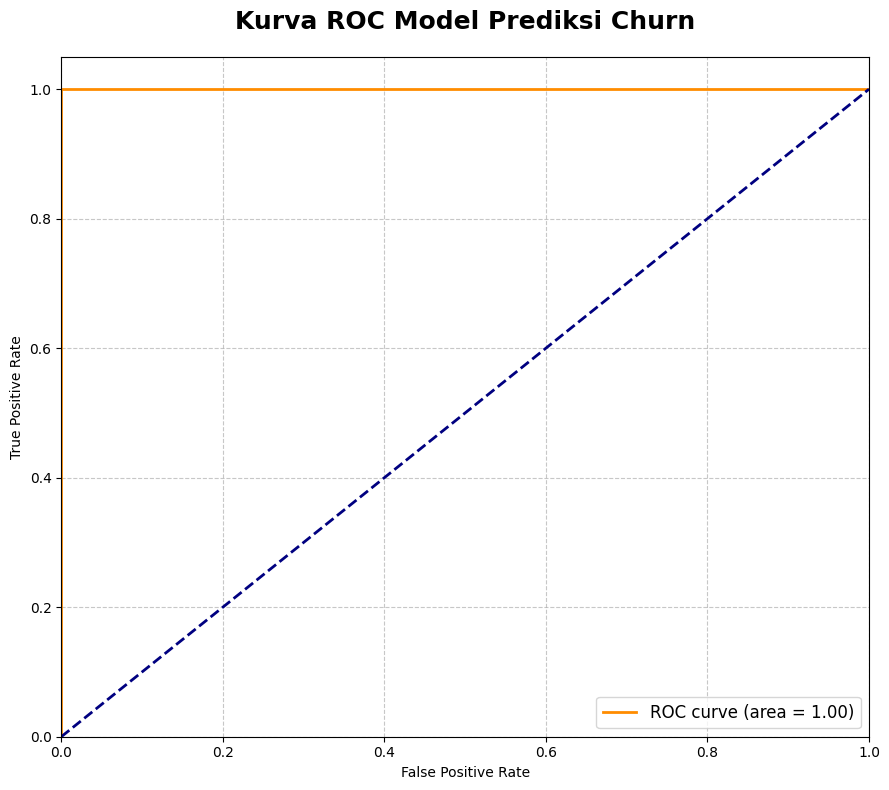

In [548]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) # Hitung AUC dari FPR dan TPR

plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis acak
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC Model Prediksi Churn', fontsize=18, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Sintesis Temuan dan Rekomendasi Terintegrasi

Berdasarkan analisis komprehensif yang telah dilakukan, kami menyajikan sintesis temuan kunci dan rekomendasi strategis yang terintegrasi untuk mendorong pertumbuhan dan profitabilitas bisnis:

## Gambaran Besar: Tantangan dan Peluang

*   **Pertumbuhan Penjualan vs. Volatilitas Profit:** Bisnis menunjukkan tren pertumbuhan penjualan yang positif dari tahun ke tahun, terutama didorong oleh lonjakan musiman di Kuartal 4 dan Kuartal 2. Namun, profitabilitas menunjukkan fluktuasi yang signifikan dan adanya periode kerugian, mengindikasikan adanya inefisiensi atau faktor pengikis profit.
*   **Kinerja Regional yang Tidak Merata:** Wilayah West dan East adalah kontributor utama penjualan dan profit, sementara Wilayah Central menunjukkan profit margin yang rendah meskipun memiliki penjualan yang tinggi.
    *   Contoh: Wilayah Central memiliki Total Sales **501.240**, tetapi Profit Margin hanya **7.92%**, jauh di bawah West (**14.94%**) dan East (**13.48%**).
*   **Diskon Mengikis Profit:** Analisis menemukan korelasi negatif yang jelas antara diskon dan profit, dengan diskon tinggi seringkali berujung pada kerugian.
    *   Koefisien korelasi antara Diskon dan Profit adalah **-0.2195**, menunjukkan hubungan negatif. Visualisasi scatter plot memperkuat temuan ini, menunjukkan bahwa diskon di atas 30% (0.3) hampir selalu menghasilkan kerugian.
*   **Segmentasi Pelanggan untuk Penargetan:** Pelanggan dapat dikelompokkan ke dalam 4 segmen yang jelas (Champions, High-Value, At-Risk, Hibernating) berdasarkan perilaku pembelian mereka (RFM).
    *   **Champions (Klaster 0):** Recency ~20 hari, Frequency ~7 kali, Monetary ~$2,713.
    *   **High-Value (Klaster 2):** Recency ~103 hari, Frequency ~8.6 kali, Monetary ~$4,773.
    *   **At-Risk (Klaster 1):** Recency ~235 hari, Frequency ~4.8 kali, Monetary ~$1,937.
    *   **Hibernating (Klaster 3):** Recency ~327 hari, Frequency ~2.6 kali, Monetary ~$432.
    *   Model prediksi churn awal menunjukkan akurasi tinggi dalam mengidentifikasi pelanggan yang Recency-nya > 180 hari (Churn = 1).
*   **Profitabilitas Produk yang Bervariasi:** Terdapat perbedaan profitabilitas yang besar antar sub-kategori.
    *   Sub-kategori paling menguntungkan: Copiers, Phones, Accessories, Paper.
    *   Sub-kategori paling merugi: Supplies, Bookcases, Tables.
*   **Tidak Ada Asosiasi Produk yang Kuat:** Market Basket Analysis tidak mengidentifikasi aturan asosiasi produk yang kuat (min_support 0.5%, min_confidence 20%), menunjukkan bahwa strategi cross-selling tradisional antar item spesifik mungkin tidak efektif.

## Solusi Terintegrasi dan Rekomendasi

Untuk mengatasi tantangan dan memanfaatkan peluang, kami merekomendasikan pendekatan strategis yang terintegrasi:

1.  **Strategi Diskon yang Dioptimalkan dan Bertarget:**
    *   **Rekomendasi:** Tinjau kembali kebijakan diskon, terutama untuk produk dengan margin rendah (seperti Supplies, Bookcases, Tables) atau di wilayah dengan profit margin rendah (seperti Central). Pertimbangkan diskon yang lebih selektif dan bertarget, fokus pada segmen pelanggan bernilai tinggi (Champions, High-Value) atau produk dengan profit margin yang lebih sehat (Copiers, Phones). Hindari diskon di atas 30% kecuali jika benar-benar diperlukan dan diimbangi dengan volume yang sangat tinggi.
    *   **Implementasi:** Gunakan wawasan dari analisis profitabilitas produk dan analisis geografis untuk menginformasikan keputusan diskon pada tingkat sub-kategori dan wilayah.

2.  **Peningkatan Efisiensi Operasional dan Profitabilitas di Wilayah Central:**
    *   **Rekomendasi:** Lakukan investigasi mendalam terhadap penyebab profit margin rendah di Wilayah Central, meskipun penjualannya tinggi. Analisis biaya operasional (termasuk logistik/pengiriman), harga pokok penjualan, atau bauran produk (apakah lebih banyak menjual produk margin rendah di sana?) di wilayah ini diperlukan untuk mengidentifikasi area perbaikan.
    *   **Implementasi:** Alihkan fokus investasi dan sumber daya ke wilayah dengan kinerja tinggi (West dan East) sambil mencari solusi spesifik untuk meningkatkan efisiensi dan profitabilitas di wilayah Central.

3.  **Kampanye Pemasaran dan Retensi Berbasis Segmentasi Pelanggan dan Prediksi Churn:**
    *   **Rekomendasi:** Manfaatkan segmentasi RFM untuk menciptakan kampanye marketing yang sangat personal dan relevan. Gunakan model prediksi churn untuk menargetkan pelanggan berisiko tinggi secara proaktif.
    *   **Implementasi:**
        *   **Champions & High-Value:** Fokus pada program loyalitas, penawaran eksklusif, akses awal produk, dan komunikasi yang membangun hubungan. Gunakan model churn untuk memantau jika ada tanda-tanda awal ketidakaktifan pada segmen bernilai tinggi ini.
        *   **At-Risk (Recency > 180 hari) & Diprediksi Churn:** Lakukan kampanye reaktivasi yang kuat dengan insentif yang menarik (diskon khusus, penawaran bundling). Coba jangkau mereka melalui berbagai saluran komunikasi.
        *   **Hibernating:** Alokasikan sumber daya marketing minimal, fokus pada kampanye massal sesekali dengan penawaran yang sangat menarik.

4.  **Optimalisasi Strategi Penawaran Produk:**
    *   **Rekomendasi:** Karena tidak ada aturan asosiasi produk spesifik yang kuat, fokuskan strategi cross-selling pada tingkat Kategori produk yang lebih luas (misalnya, tawarkan Aksesoris Teknologi saat pelanggan membeli Telepon) atau kembangkan paket bundling produk yang populer berdasarkan volume penjualan atau profitabilitas (mengacu pada analisis profitabilitas produk).
    *   **Implementasi:** Tingkatkan visibilitas produk komplementer di etalase (fisik dan online) berdasarkan kategori, atau tawarkan bundling produk dengan margin yang baik.

5.  **Perencanaan & Penganggaran Berbasis Peramalan Penjualan:**
    *   **Rekomendasi:** Gunakan model peramalan penjualan (Prophet) yang memprediksi lonjakan di Q4 dan Q2 untuk perencanaan inventaris yang lebih akurat. Manfaatkan periode penjualan yang lebih tenang (seperti Feb-Mar) untuk operasional internal (pemeliharaan, pelatihan). Gunakan angka prediksi (yhat) dan rentang kepercayaannya (yhat_lower, yhat_upper) untuk menyusun anggaran pendapatan dan kas yang lebih realistis.
    *   **Implementasi:** Sinkronkan data peramalan dengan tim operasional (manajemen stok) dan keuangan (penganggaran) untuk memastikan kesiapan dan efisiensi sepanjang tahun.

Dengan mengimplementasikan rekomendasi yang terintegrasi ini, didukung oleh wawasan berbasis data dari analisis profitabilitas, tren waktu, kinerja regional, segmentasi pelanggan, dan prediksi churn, bisnis dapat beralih dari reaktif menjadi proaktif, mengoptimalkan sumber daya, meningkatkan efisiensi, mengurangi kerugian, dan pada akhirnya mendorong pertumbuhan profitabilitas yang berkelanjutan.